Here we visualize filters and outputs using the network architecture proposed by Krizhevsky et al. for ImageNet and implemented in `caffe`.

(This page follows DeCAF visualizations originally by Yangqing Jia.)

First, import required modules, set plotting parameters, and run `./scripts/download_model_binary.py models/bvlc_reference_caffenet` to get the pretrained CaffeNet model if it hasn't already been fetched.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '../../../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe
from caffe.proto import caffe_pb2
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

#import os
#if not os.path.isfile(caffe_root + 'examples/snsd_classify/snsd_cifar10_full_150717_iter_60000.caffemodel'):
#    print("Downloading pre-trained CaffeNet model...")
#    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

Set Caffe to CPU mode, load the net in the test phase for inference, and configure input preprocessing.

In [24]:
caffe.set_mode_cpu()
net = caffe.Net(caffe_root + 'examples/snsd_classify/snsd_cifar10_full.prototxt',
                caffe_root + 'examples/snsd_classify/snsd_cifar10_full_150717_iter_60000.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
mean_blob = caffe_pb2.BlobProto()
with open( caffe_root + 'examples/snsd_classify/snsd_mean.binaryproto') as f:
        mean_blob.ParseFromString(f.read())
mean_array = np.asarray(mean_blob.data, dtype=np.float32).reshape((mean_blob.channels,mean_blob.height,mean_blob.width))
transformer.set_mean('data', mean_array) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
#transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

(1, 3, 60, 60)


Classify the image by reshaping the net for the single input then doing the forward pass.

In [25]:
net.blobs['data'].reshape(1,3,60,60)
net.blobs['data'].data[...] = transformer.preprocess('data', caffe.io.load_image(caffe_root + 'examples/snsd_classify/snsd_data/8/yoona_0003.jpg'))
out = net.forward()
print("Predicted class is #{}.".format(out['prob'].argmax()))

Predicted class is #8.


The layer features and their shapes (1 is the batch size, corresponding to the single input image in this example).

In [26]:
[(k, v.data.shape) for k, v in net.blobs.items()]

[('data', (1, 3, 60, 60)),
 ('conv1', (1, 60, 60, 60)),
 ('pool1', (1, 60, 30, 30)),
 ('norm1', (1, 60, 30, 30)),
 ('conv2', (1, 32, 30, 30)),
 ('pool2', (1, 32, 15, 15)),
 ('norm2', (1, 32, 15, 15)),
 ('conv3', (1, 64, 15, 15)),
 ('pool3', (1, 64, 7, 7)),
 ('ip1', (1, 64)),
 ('ip2', (1, 10)),
 ('prob', (1, 10))]

The parameters and their shapes. The parameters are `net.params['name'][0]` while biases are `net.params['name'][1]`.

In [27]:
[(k, v[0].data.shape) for k, v in net.params.items()]

[('conv1', (60, 3, 5, 5)),
 ('conv2', (32, 60, 5, 5)),
 ('conv3', (64, 32, 5, 5)),
 ('ip1', (64, 3136)),
 ('ip2', (10, 64))]

Helper functions for visualization

In [28]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

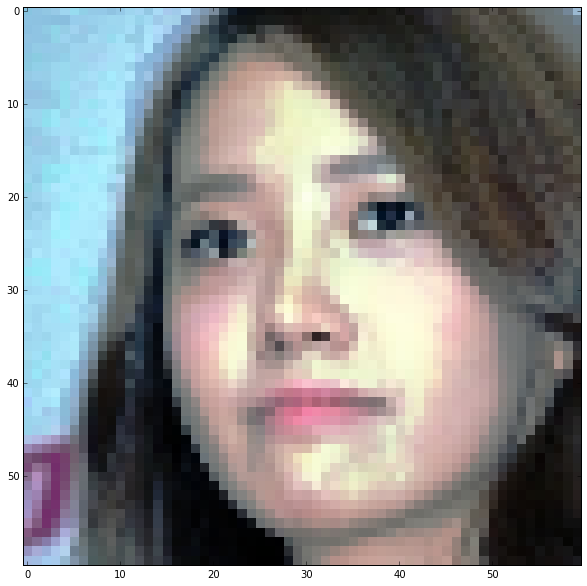

In [29]:
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[0]))

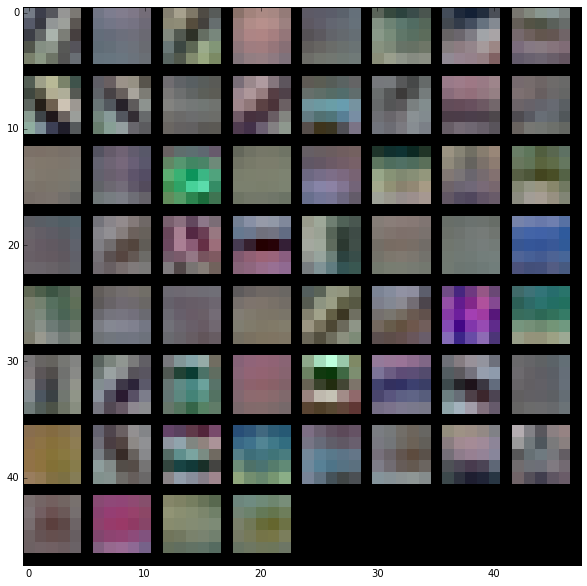

In [30]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

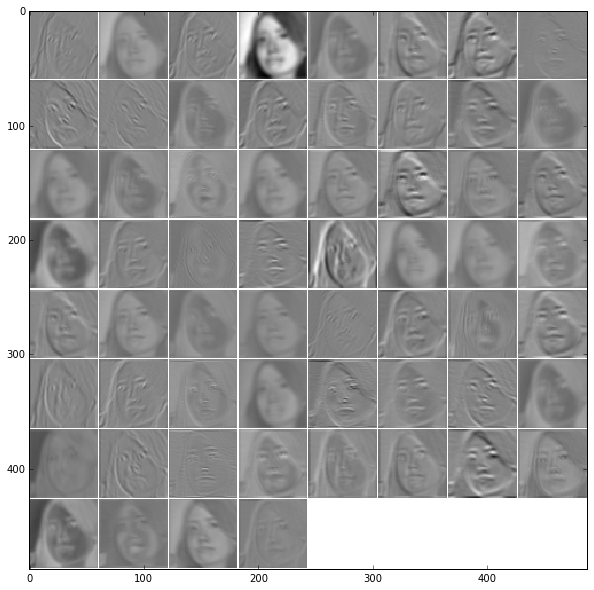

In [31]:
feat = net.blobs['conv1'].data[0, :60]
vis_square(feat, padval=1)

In [68]:
filters = net.params['conv2'][0].data
vis_square(filters[:60].reshape(60**2, 5, 5))

ValueError: total size of new array must be unchanged

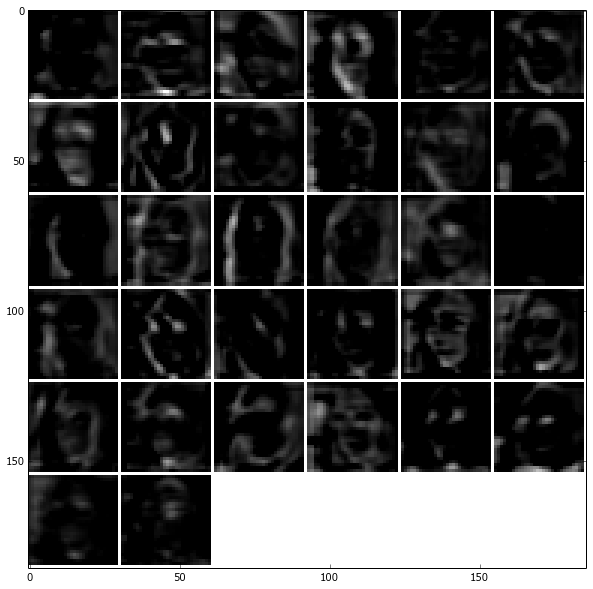

In [20]:
feat = net.blobs['conv2'].data[0, :36]
vis_square(feat, padval=1)

The third layer output, `conv3` (rectified, all 384 channels)

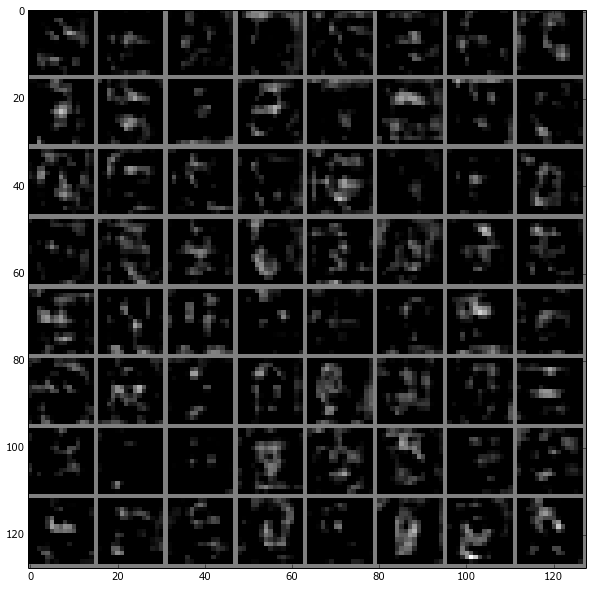

In [21]:
feat = net.blobs['conv3'].data[0]
vis_square(feat, padval=0.5)

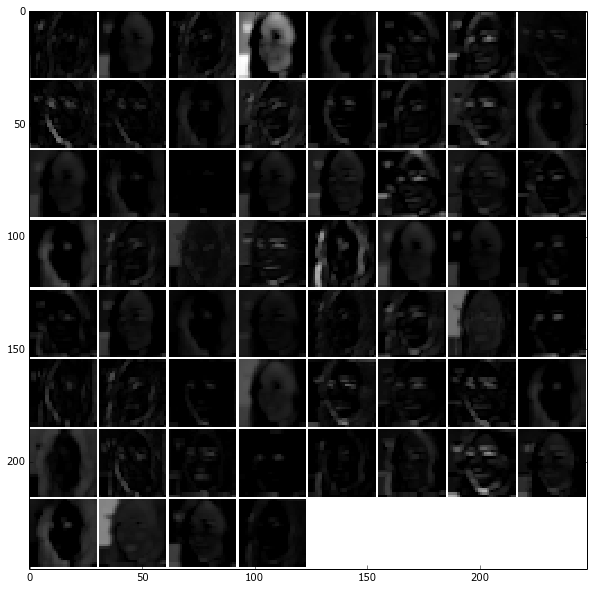

In [22]:
feat = net.blobs['pool1'].data[0]
vis_square(feat, padval=1)

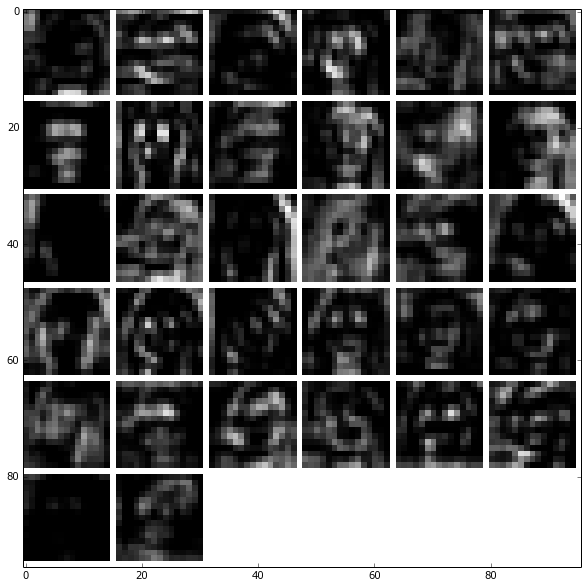

In [46]:
feat = net.blobs['pool2'].data[0]
vis_square(feat, padval=1)

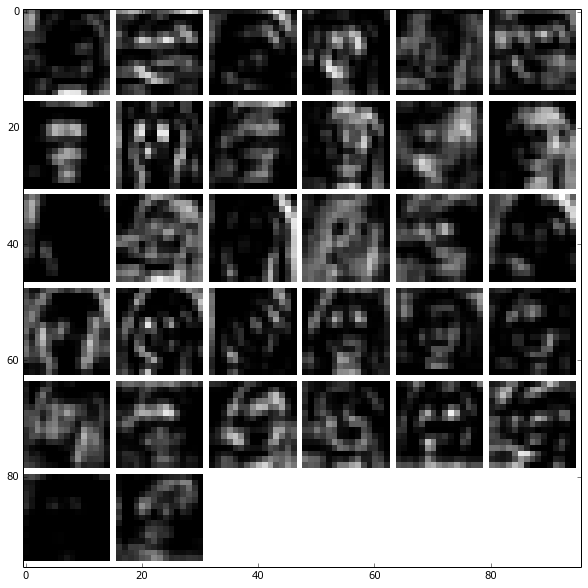

In [52]:
feat = net.blobs['norm2'].data[0]
vis_square(feat, padval=1)

(64, 7, 7)
3136


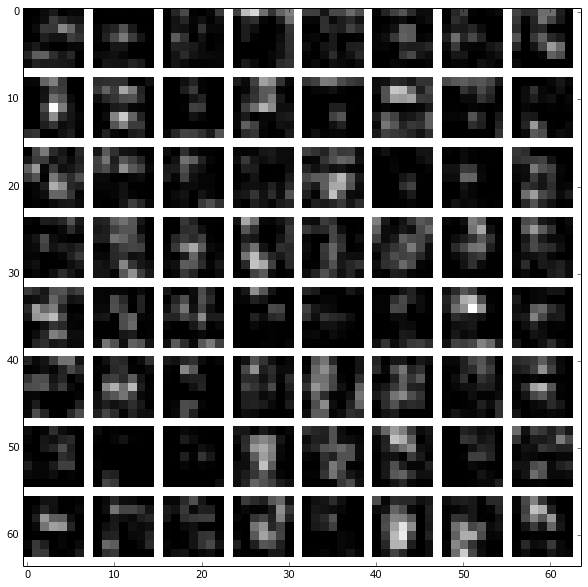

In [26]:
feat = net.blobs['pool3'].data[0]
vis_square(feat, padval=1)
print feat.shape
print feat.size

(64,)


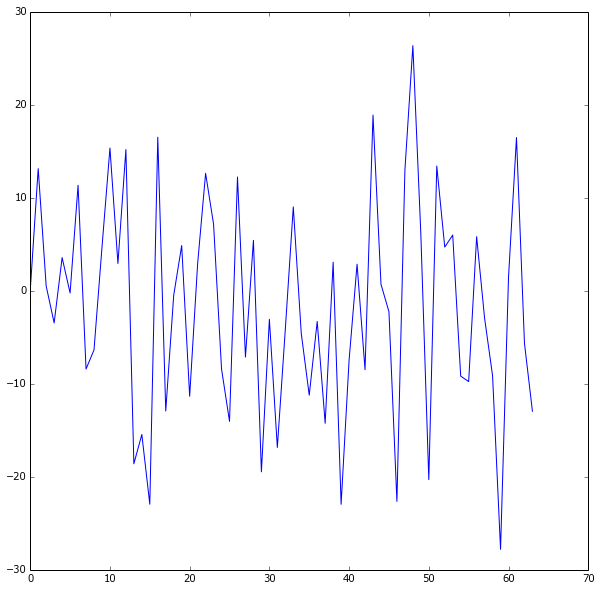

In [25]:
feat = net.blobs['ip1'].data[0]
plt.plot(feat.flat)
print feat.shape

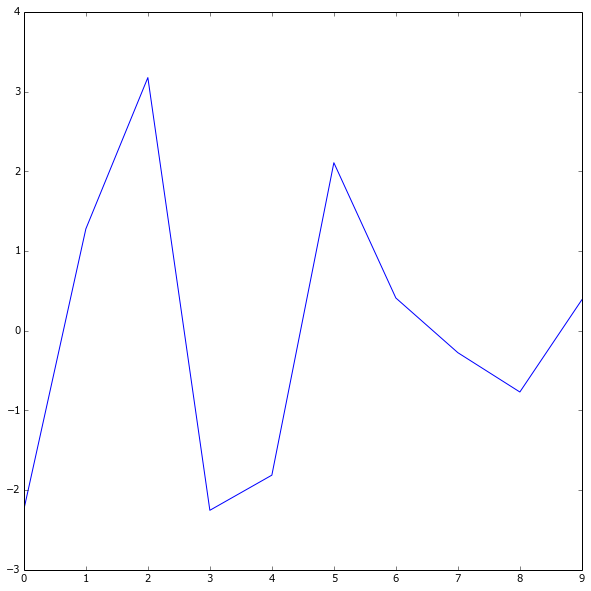

In [11]:
feat = net.blobs['ip2'].data[0]
plt.plot(feat.flat)

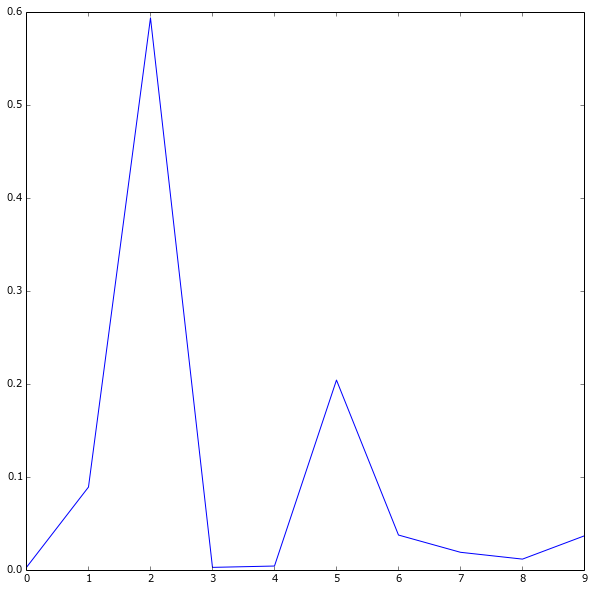

In [40]:
feat = net.blobs['prob'].data[0]
plt.plot(feat.flat)